In [1]:
import croissant as cro

from astropy.units import K as Kelvin, s as seconds
import healpy
from lunarsky import Time
import matplotlib.pyplot as plt
import numpy as np

In spherical coordinates, where $\theta$ is the polar angle, the power of a dipole antenna is given by:
$$P(\theta, \nu) \propto (L\nu)^2 \cos^2{\theta} $$

In [2]:
# 1 deg spacing, must be radians
theta = np.linspace(0, np.pi, num=181)
theta.shape = (1, -1, 1)
phi = np.linspace(0, 2 * np.pi, num=360, endpoint=False)
phi.shape = (1, 1, -1)
# 1 MHz resolution frequency
freq = np.linspace(1, 50, num=50)
freq.shape = (-1, 1, 1)
# dipole beam
power = freq**2 * np.cos(theta)**2
power = np.repeat(power, phi.size, axis=-1)
power = np.ones_like(power)

In [3]:
beam = cro.beam.Beam(power, theta=theta, phi=phi, frequencies=freq, coords="topocentric")

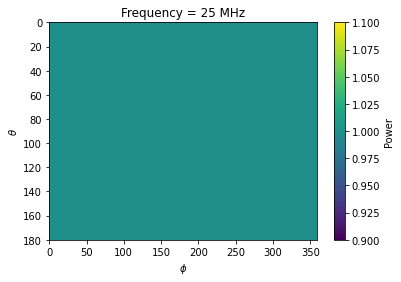

In [4]:
plot_freq = 25  # MHz
freq_ix = np.argmin(np.abs(beam.frequencies-plot_freq))
ex = [beam.phi.min(), beam.phi.max(), beam.theta.max(), beam.theta.min()]
ex_deg = [np.rad2deg(bd) for bd in ex]
plt.figure()
plt.imshow(beam.data[freq_ix], aspect="auto", extent=ex_deg)
plt.colorbar(label="Power")
plt.title(f"Frequency = {beam.frequencies[freq_ix]:.0f} MHz")
plt.xlabel("$\\phi$")
plt.ylabel("$\\theta$")
plt.show()

We use the Global Sky Model (Zheng et al 2016) at 25 MHz as the sky model and extrpolate it by a power law to other frequencies. It has a built-in interface in the sky module of croissant.

In [5]:
sky = cro.sky.Sky.gsm(beam.frequencies, power_law=True, gen_freq=25, spectral_index=-2.5)

In [6]:
lmax = 32
loc = (37.87, 122.27, 0)
t_start = Time("2022-06-01 23:09:16")
t_end = t_start + cro.constants.sidereal_day_earth * seconds
horizon = np.ones_like(beam.data)
sim = cro.simulator.Simulator(
    beam, sky, obs_loc=loc, t_start=t_start, N_times=300, t_end=t_end, moon=False, lmax=lmax, horizon=None
)

In [11]:
sim.beam.total_power / (sim.beam.compute_total_power())

array([1.98269378, 1.98269378, 1.98269378, 1.98269378, 1.98269378,
       1.98269378, 1.98269378, 1.98269378, 1.98269378, 1.98269378,
       1.98269378, 1.98269378, 1.98269378, 1.98269378, 1.98269378,
       1.98269378, 1.98269378, 1.98269378, 1.98269378, 1.98269378,
       1.98269378, 1.98269378, 1.98269378, 1.98269378, 1.98269378,
       1.98269378, 1.98269378, 1.98269378, 1.98269378, 1.98269378,
       1.98269378, 1.98269378, 1.98269378, 1.98269378, 1.98269378,
       1.98269378, 1.98269378, 1.98269378, 1.98269378, 1.98269378,
       1.98269378, 1.98269378, 1.98269378, 1.98269378, 1.98269378,
       1.98269378, 1.98269378, 1.98269378, 1.98269378, 1.98269378])

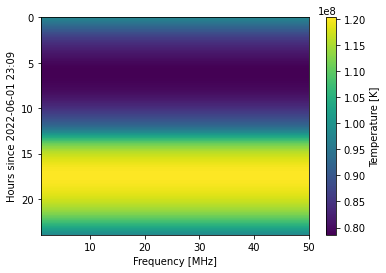

In [12]:
sim.run(dpss=False)
sim.waterfall *= sim.beam.total_power / (sim.beam.compute_total_power())  # account for horizon cutoff...
sim.plot(power=2.5)

In [13]:
from pyuvsim import simsetup
t_arr = sim.t_start + sim.dt * seconds
uvd = simsetup.initialize_uvdata_from_keywords(
    array_layout={0: [0,0,0]},
    telescope_location=loc,
    telescope_name="croissant",
    freq_array=sim.frequencies*1e6,
    time_array=t_arr.to_value("jd"),
    bls=[(0,0)],
    complete=True,
    write_files=False,
)

Cannot check consistency of a string-mode BeamList! Set force=True to force consistency checking.


In [14]:
# sky model
from pyradiosky import SkyModel

hpx_inds = np.arange(sky.npix)
stokes = np.zeros((4, 1, sky.npix)) * Kelvin
stokes[0, :, :] = healpy.Rotator(coord="gc").rotate_map_alms(sky.data[0]) * Kelvin  # in equatorial

diffuse_params = {
    'component_type': "healpix",
    'nside': sky.nside,
    'hpx_inds': hpx_inds,
    'hpx_order': "ring",
    'spectral_type': "spectral_index",
    'reference_frequency': np.full(sky.npix, sim.frequencies[0]),
    'spectral_index': np.full(sky.npix, -2.5),
    'stokes': stokes,
    'frame': "icrs"
}
diffuse_model = SkyModel(**diffuse_params)

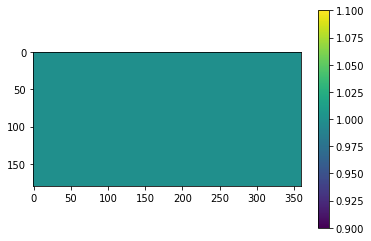

In [15]:
# beam
from pyuvsim import AnalyticBeam
uniform_beam = AnalyticBeam("uniform")


p, t = [x.ravel() for x in np.meshgrid(sim.beam.phi, sim.beam.theta)]
ab_data = uniform_beam.interp(p, t, sim.frequencies*1e6)[0][1, 0, 0]
#ab_data = uniform_beam.interp(p, t, sim.frequencies*1e6)[0][0, 0, 1]
ab_data.shape = (-1, sim.beam.theta.size, sim.beam.phi.size)

plt.figure()
plt.imshow(ab_data[0])
plt.colorbar()
plt.show()

# VisCPU

In [16]:
from copy import deepcopy
from hera_sim.visibilities import ModelData
data_model = ModelData(
    uvdata=deepcopy(uvd),
    sky_model=deepcopy(diffuse_model),
    beam_ids=[0],
    beams=[deepcopy(uniform_beam)],
    normalize_beams=False,
)

git is not installed. Rephasing tool unavailable.


In [17]:
from hera_sim.visibilities import VisCPU, VisibilitySimulation
t_mid = sim.t_start + 1/2 * sim.dt[-1] * seconds
vis_class = VisCPU(use_pixel_beams=False, precision=1, ref_time=t_mid, correct_source_positions=True)
vis_cpu = VisibilitySimulation(deepcopy(data_model), vis_class, sky.nside)
_ = vis_cpu.simulate()

In [18]:
jy2k = sky.data[:, 0] / vis_cpu.data_model.sky_model.stokes[0, :, 0].value  # jansky to K conversion
vis_wfall = vis_cpu.data_model.uvdata.get_data((0, 0, "xx")).real.copy()
vis_wfall *= jy2k  # jy to K
vis_wfall *= 2  # 2 pols
vis_wfall *= 4*np.pi / sky.npix  # pixel normalization
vis_wfall /= 2*np.pi  # beam normalization (above horizon only..)

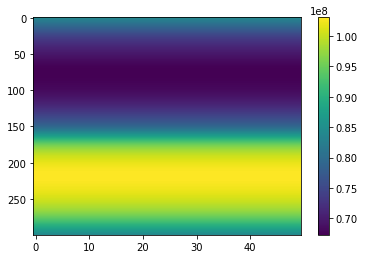

In [19]:
plt.figure()
plt.imshow(vis_wfall * sim.frequencies**2.5, aspect="auto")
plt.colorbar()
plt.show()

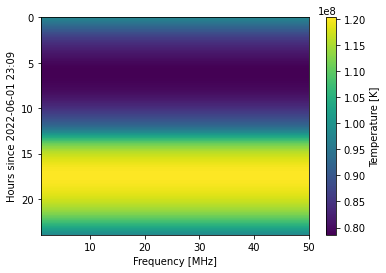

In [20]:
sim.plot(power=2.5)

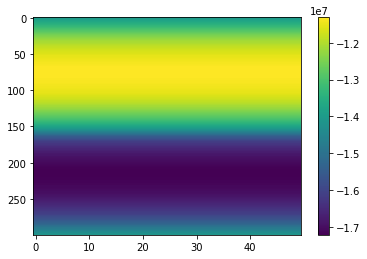

In [21]:
plt.figure()
plt.imshow((vis_wfall - sim.waterfall) * sim.frequencies**2.5, aspect="auto")
plt.colorbar()
plt.show()

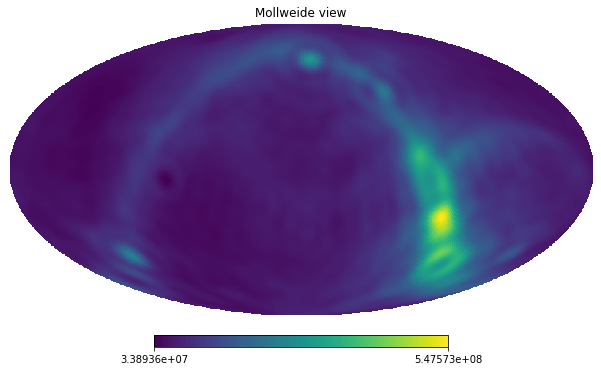

In [47]:
eq_sky = sim.sky.hp_map()
healpy.mollview(eq_sky[0])

# mean above horizon
npix = eq_sky.shape[-1]
mean_sky = eq_sky[:, :npix//2].mean(axis=1)

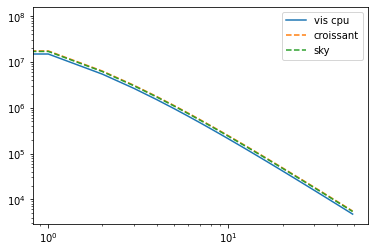

In [48]:
plt.figure()
plt.plot(vis_wfall[0], label="vis cpu")
plt.plot(sim.waterfall[0], ls="--", label="croissant")
plt.plot(mean_sky, ls="--", label="sky")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

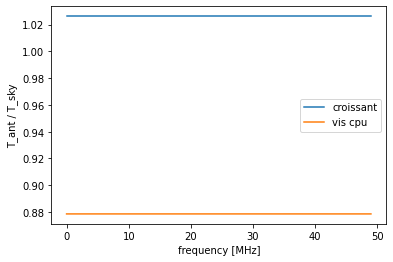

In [49]:
plt.figure()
plt.plot(sim.waterfall[0] / mean_sky, label="croissant")
plt.plot(vis_wfall[0] / mean_sky, label="vis cpu")
plt.legend()
#plt.yscale("log")
plt.xlabel("frequency [MHz]")
plt.ylabel("T_ant / T_sky")
plt.show()

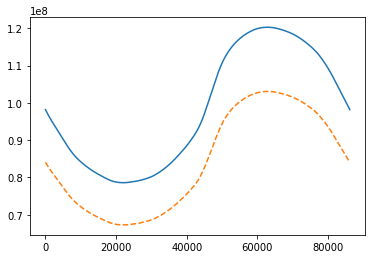

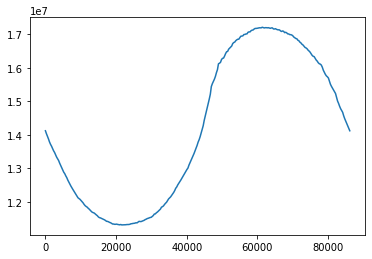

In [25]:
plt.figure()
plt.plot(sim.dt, sim.waterfall[:, 0])
plt.plot(sim.dt, vis_wfall[:, 0], ls="--")
plt.show()

plt.figure()
plt.plot(sim.dt, sim.waterfall[:, 0] - vis_wfall[:, 0])
plt.show()

# pyuvsim

In [23]:
from hera_sim.visibilities import UVSim

uvsim = VisibilitySimulation(deepcopy(data_model), UVSim(), sky.nside)
_ = uvsim.simulate()

UVSim requires time-ordered data. Ensuring that order in UVData...


Nbls: 1
Ntimes: 300
Nfreqs: 50
Nsrcs: 49152
Tasks:  15000.0
1.00% completed. 0:00:02.643471  elapsed. 0:04:21.703653 remaining. 

2.00% completed. 0:00:05.858939  elapsed. 0:04:47.088031 remaining. 

3.00% completed. 0:00:09.298526  elapsed. 0:05:00.652327 remaining. 

4.00% completed. 0:00:12.698893  elapsed. 0:05:04.773439 remaining. 

5.00% completed. 0:00:16.099853  elapsed. 0:05:05.897199 remaining. 

6.00% completed. 0:00:19.678311  elapsed. 0:05:08.293541 remaining. 

7.00% completed. 0:00:23.074949  elapsed. 0:05:06.567180 remaining. 

8.00% completed. 0:00:26.555698  elapsed. 0:05:05.390526 remaining. 

9.00% completed. 0:00:30.066575  elapsed. 0:05:04.006481 remaining. 

10.00% completed. 0:00:33.482516  elapsed. 0:05:01.342644 remaining. 

11.00% completed. 0:00:36.827807  elapsed. 0:04:57.970438 remaining. 

12.00% completed. 0:00:40.200066  elapsed. 0:04:54.800485 remaining. 

13.00% completed. 0:00:43.596107  elapsed. 0:04:51.758562 remaining. 

14.00% completed. 0:00:46.

In [30]:
uvsim_wfall = uvsim.data_model.uvdata.get_data((0, 0, "xx")).real.copy()
uvsim_wfall *= jy2k  # jy to K
uvsim_wfall *= 2  # 2 pols
uvsim_wfall *= 4*np.pi / sky.npix  # pixel normalization
uvsim_wfall /= sim.beam.total_power  # beam normalization

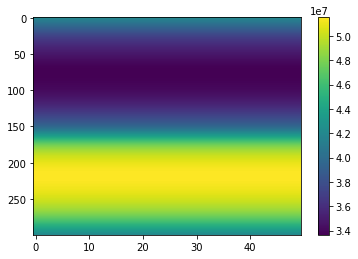

In [32]:
plt.figure()
plt.imshow(uvsim_wfall * sim.frequencies**2.5, aspect="auto")
plt.colorbar()
plt.show()

# HERA-Sim

In [664]:
from hera_sim import Simulator
hera = Simulator(data=deepcopy(uvd))

In [671]:
hera.add("diffuse_foreground")

You have not specified how to seed the random state. This effect might not be exactly recoverable.


ValueError: A sky temperature model must be specified in order to use this function.